#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 14
**CH14B Predicting AirBnB apartment prices: selecting a regression model**

using the airbnb dataset

version 0.8 2021-07-15

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from mizani.formatters import percent_format
from plotnine import *
import regex as re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]
# location folders
data_in = "../../da_data_repo/airbnb/clean/"
data_out = dirname + "da_case_studies/ch14-airbnb-reg/"
output = "../../da_case_studies/ch14-airbnb-reg/output/"
func = "../ch00-tech-prep/"
sys.path.append(func)


from py_helper_functions import *

### Part 1

In [3]:
#############
# Load data #
#############
# Import data
# Used area
area = "hackney"
data = pd.read_csv("airbnb_"+area+"_workfile_adj.csv")
data=data[data.columns.drop(list(data.filter(regex='Unnamed')))]

In [4]:
######################
# Quick look at data #
######################
data.describe()

,usd_cleaning_fee,usd_price_day,p_host_response_rate,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,...,f_bathroom,ln_number_of_reviews,f_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,f_minimum_nights
count,2769.000000,4496.000000,0.0,4496.000000,4487.000000,3073.000000,4496.000000,4496.000000,3147.000000,4496.000000,...,4487.000000,4496.000000,4495.000000,3146.000000,3146.000000,3146.000000,3.147000e+03,3.147000e+03,3073.000000,4495.000000
mean,31.439870,80.556940,NaN,2.864324,1.225986,93.323788,10.141904,1.385454,0.946295,5.991770,...,1.150435,1.414416,0.745050,5.813246,34.920619,214.912424,4.386975e+05,5.008933e+08,4.529253,2.029366
std,25.871418,58.915794,NaN,1.722148,0.480064,9.133501,22.342473,0.996658,1.143208,11.255617,...,0.379318,1.318117,0.529467,1.061670,11.357470,96.884368,6.959114e+05,1.179754e+09,0.130507,0.838032
min,4.000000,10.000000,NaN,1.000000,0.000000,20.000000,0.000000,1.000000,0.020000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732,1.000000
25%,15.000000,40.000000,NaN,2.000000,1.000000,90.000000,0.000000,1.000000,0.210000,0.000000,...,1.000000,0.000000,0.000000,5.269144,27.763878,146.291911,3.763600e+04,7.301384e+06,4.499810,1.000000
50%,25.000000,65.000000,NaN,2.000000,1.000000,96.000000,2.000000,1.000000,0.520000,0.000000,...,1.000000,1.098612,1.000000,6.006350,36.076248,216.686649,1.640250e+05,6.643012e+07,4.564348,2.000000
75%,40.000000,100.000000,NaN,4.000000,1.500000,100.000000,10.000000,1.000000,1.190000,10.000000,...,1.000000,2.397895,1.000000,6.512487,42.412491,276.210824,4.529300e+05,3.048232e+08,4.605170,3.000000
max,500.000000,850.000000,NaN,16.000000,8.000000,100.000000,290.000000,12.000000,9.730000,200.000000,...,2.000000,5.673323,2.000000,7.773594,60.428771,469.748759,5.650129e+06,1.343036e+10,4.605170,3.000000


In [5]:
# where do we have missing variables now?
to_filter=data.isna().sum()
to_filter[to_filter>0].index

Index(['usd_cleaning_fee', 'p_host_response_rate', 'n_bathrooms',
       'n_review_scores_rating', 'n_reviews_per_month', 'n_beds',
       'n_days_since', 'ln_accommodates2', 'ln_beds', 'f_bathroom',
       'f_number_of_reviews', 'ln_days_since', 'ln_days_since2',
       'ln_days_since3', 'n_days_since2', 'n_days_since3',
       'ln_review_scores_rating', 'f_minimum_nights'],
      dtype='object')

In [6]:
# what to do with missing values?
# 1. drop if no target (already did)
data=data.dropna(subset=['price'])

In [7]:
# 2. imput when few, not that important
data['n_bathrooms']=data['n_bathrooms'].fillna(np.nanmedian(data['n_bathrooms']))
data['n_beds']=data['n_beds'].fillna(data['n_accommodates'])
data['f_bathroom']=data['f_bathroom'].fillna(1)
data['f_minimum_nights']=data['f_minimum_nights'].fillna(1)
data['f_number_of_reviews']=data['f_number_of_reviews'].fillna(1)
data['ln_beds']=data['ln_beds'].fillna(0)

In [8]:
data['n_bathrooms'].describe()

count    4496.000000
mean        1.225534
std         0.479690
min         0.000000
25%         1.000000
50%         1.000000
75%         1.500000
max         8.000000
Name: n_bathrooms, dtype: float64

In [9]:
# 3. drop columns when many missing not imortant
data=data.drop(["usd_cleaning_fee", "p_host_response_rate"],axis=1)

In [10]:
# where do we have missing variables now?
to_filter=data.isna().sum()
to_filter[to_filter>0].index

Index(['n_review_scores_rating', 'n_reviews_per_month', 'n_days_since',
       'ln_accommodates2', 'ln_days_since', 'ln_days_since2', 'ln_days_since3',
       'n_days_since2', 'n_days_since3', 'ln_review_scores_rating'],
      dtype='object')

In [11]:
for var in ["flag_days_since","flag_review_scores_rating","flag_reviews_per_month"]:
    data[var]=[int(x) for x in data[var.replace('flag','n')].isna()]

In [12]:
# 4. Replace missing variables re reviews with zero, when no review + add flags
data['n_days_since']=data['n_days_since'].fillna(np.nanmedian(data['n_days_since']))
data['n_review_scores_rating']=data['n_review_scores_rating'].fillna(np.nanmedian(data['n_review_scores_rating']))
data['n_reviews_per_month']=data['n_reviews_per_month'].fillna(np.nanmedian(data['n_reviews_per_month']))

In [13]:
data.flag_days_since.value_counts()

0    3147
1    1349
Name: flag_days_since, dtype: int64

In [14]:
#for var in to_filter[to_filter>0].index:
#    data[var]=data[var].fillna(0)
    

In [15]:
# Look at data
data.price.describe()

count    4496.000000
mean       80.556940
std        58.915794
min        10.000000
25%        40.000000
50%        65.000000
75%       100.000000
max       850.000000
Name: price, dtype: float64

In [16]:
# where do we have missing variables now?
to_filter=data.isna().sum()
to_filter[to_filter>0]

ln_accommodates2            535
ln_days_since              1350
ln_days_since2             1350
ln_days_since3             1350
n_days_since2              1349
n_days_since3              1349
ln_review_scores_rating    1423
dtype: int64

In [17]:
###################################
# Business logic- define our prediction problem
###################################
# Decision
# Size, we need a normal apartment, 1-7persons
data=data.loc[data.n_accommodates < 8]

In [18]:
data.to_csv('airbnb_hackney_work.csv', index=False)

In [19]:
#####################################
# Look at some descriptive statistics
#####################################
#How is the average price changing in my district by `property_type`, `room_type` and the `bed_type`?
data.groupby(["f_property_type", "f_room_type"]).agg(mean_price=("price", np.mean))

mean_price
f_property_type f_room_type                
Apartment       Entire home/apt  106.364341
                Private room      48.034439
                Shared room       50.708333
House           Entire home/apt  134.794118
                Private room      42.931487
                Shared room       38.666667

In [20]:
data.groupby(["f_bed_type"]).agg(mean_price=("price", np.mean))

,mean_price
f_bed_type,
Couch,49.091954
Real Bed,77.838365


In [21]:
data.price.describe()

count    4393.000000
mean       77.269064
std        53.265471
min        10.000000
25%        40.000000
50%        65.000000
75%        99.000000
max       850.000000
Name: price, dtype: float64

In [22]:
# NB all graphs, we exclude  extreme values of price
datau=data.loc[data.price<400]

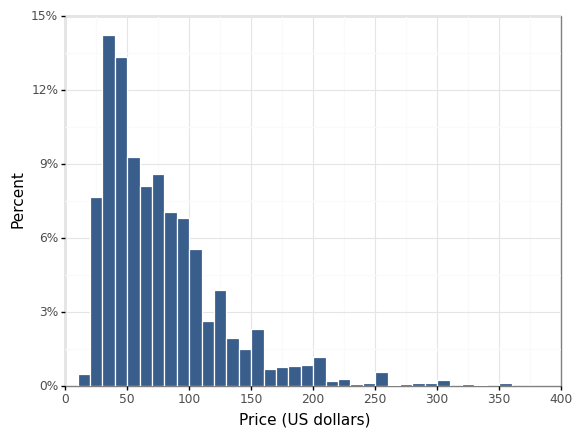

<ggplot: (314786214)>

In [23]:
# Distribution of price by type below 400# Histograms# price
(
    ggplot(datau, aes(x="price"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=10,
        fill=color[0],
        color="white",
        alpha=0.8,
        boundary=0,
        closed="left",
    )
    + labs(x="Price (US dollars)", y="Percent")
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.15),
        breaks=seq(0, 0.16, by=0.03),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.00), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
)

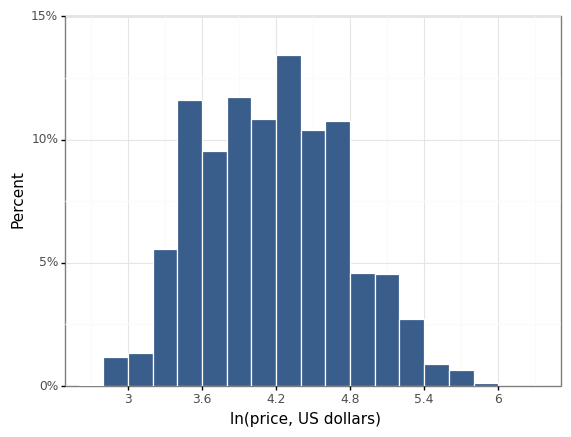

<ggplot: (314851407)>

In [24]:
(
    ggplot(datau, aes(x="ln_price"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.2,
        fill=color[0],
        color="white",
        alpha=0.8,
        boundary=0,
        closed="left",
    )
    + coord_cartesian(xlim=(2.5, 6.5))
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.15),
        breaks=seq(0, 0.16, by=0.05),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.01), breaks=seq(2.4, 6.7, 0.6))
    + labs(x="ln(price, US dollars)", y="Percent")
    + theme_bw()
)

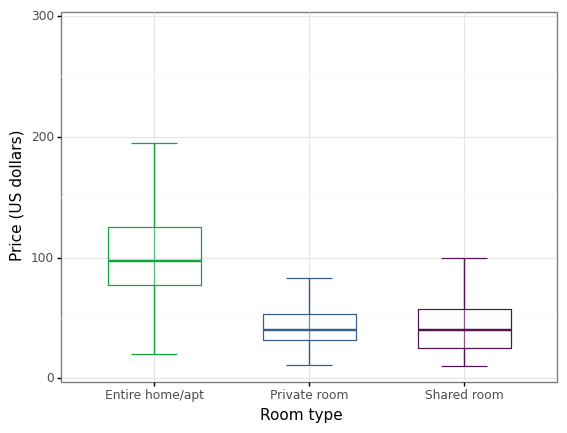

<ggplot: (314851024)>

In [25]:
## Boxplot of price by room type
(
    ggplot(datau, aes(x="f_room_type", y="price"))
    + stat_boxplot(
        aes(group="f_room_type"),
        geom="errorbar",
        width=0.3,
        color=(color[1], color[0], color[2]),
        size=0.5,
        na_rm=True,
    )
    + geom_boxplot(
        aes(group="f_room_type"),
        color=(color[1], color[0], color[2]),
        # fill=(color[1], color[0], color[2]),
        size=0.5,
        width=0.6,
        alpha=0.3,
        na_rm=True,
        outlier_shape="",
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 300), breaks=seq(0, 301, 100))
    + labs(x="Room type", y="Price (US dollars)")
    + theme_bw()
)

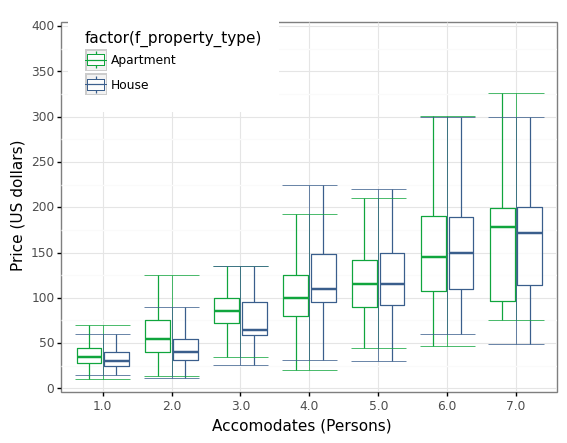

<ggplot: (314957499)>

In [26]:
(
    ggplot(
        datau,
        aes(
            x="factor(n_accommodates)",
            y="price",
            # fill="factor(f_property_type)",
            color="factor(f_property_type)",
        ),
    )
    + geom_boxplot(alpha=0.8, na_rm=True, outlier_shape="", width=0.8, stat="boxplot")
    + stat_boxplot(geom="errorbar", width=0.8, size=0.3, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_fill_manual(name="", values=(color[1], color[0]))
    + labs(x="Accomodates (Persons)", y="Price (US dollars)")
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
    + theme(legend_position=(0.3, 0.8))
)

### Part2

In [27]:
data = pd.read_csv('airbnb_hackney_work.csv')

In [28]:
#####################
# Setting up models #
#####################
# Basic Variables
basic_lev = (
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "n_days_since",
    "flag_days_since",
)
basic_add = ("f_bathroom", "f_cancellation_policy", "f_bed_type")
reviews = ("f_number_of_reviews", "n_review_scores_rating", "flag_review_scores_rating")
poly_lev = ("n_accommodates2", "n_days_since2", "n_days_since3")
# not use p_host_response_rate due to missing obs
amenities = list(data.filter(regex="^d_.*"))

In [29]:
#################################################
# Look for interactions
################################################

In [30]:
## Helper functions
def price_diff_by_variables(df, factor_var, dummy_var):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + ylab("Mean Price")
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
        )
        + scale_fill_grey()
    )

    return plot


def price_diff_by_variables2(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )

    return plot

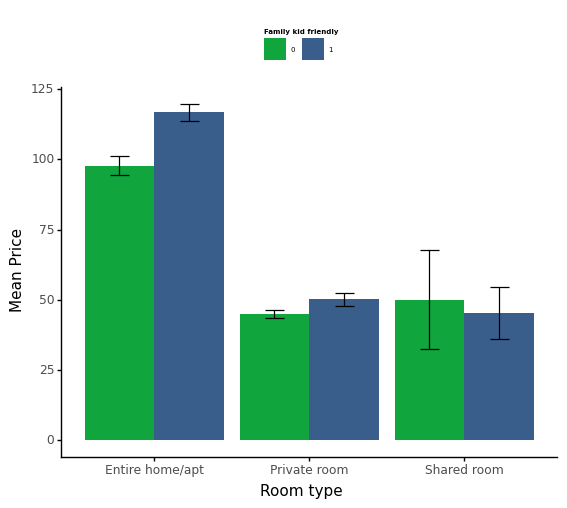

<ggplot: (314985180)>

In [31]:
price_diff_by_variables2(data,"f_room_type","d_familykidfriendly","Room type", "Family kid friendly")

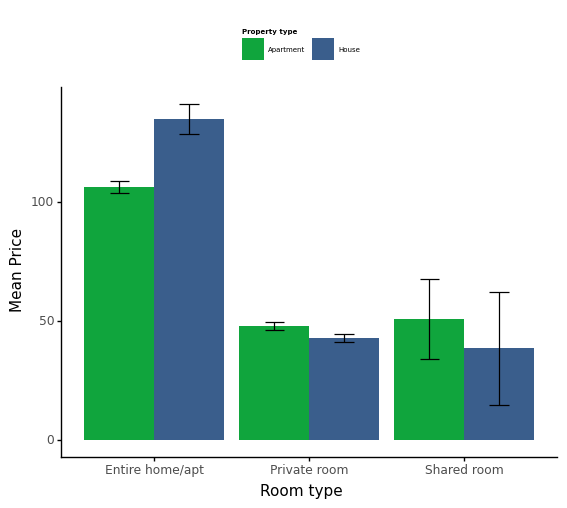

<ggplot: (314990315)>

In [32]:
price_diff_by_variables2(data, "f_room_type", "f_property_type", "Room type", "Property type")

In [33]:
#Look up canelation policy

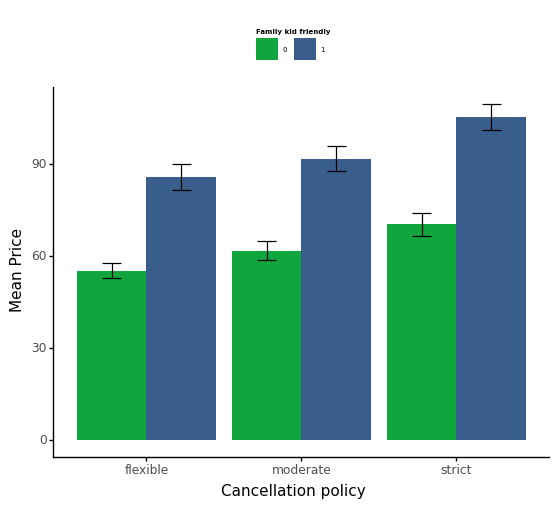

<ggplot: (314932104)>

In [34]:
price_diff_by_variables2(data, "f_cancellation_policy", "d_familykidfriendly", "Cancellation policy", "Family kid friendly")

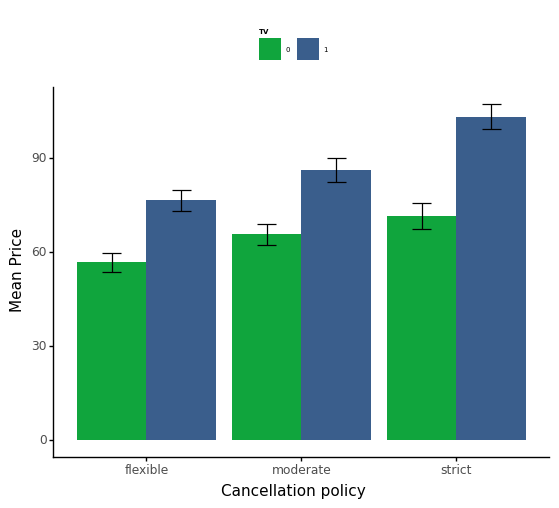

<ggplot: (314854952)>

In [35]:
price_diff_by_variables2(data, "f_cancellation_policy", "d_tv", "Cancellation policy", "TV")

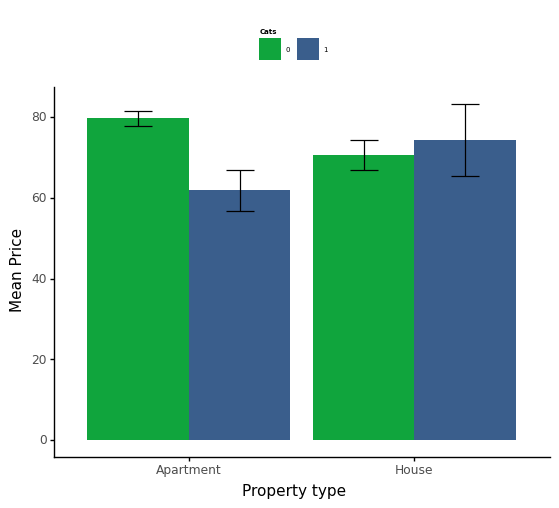

<ggplot: (315157435)>

In [36]:
#Look up property type
price_diff_by_variables2(data, "f_property_type", "d_cats", "Property type", "Cats")

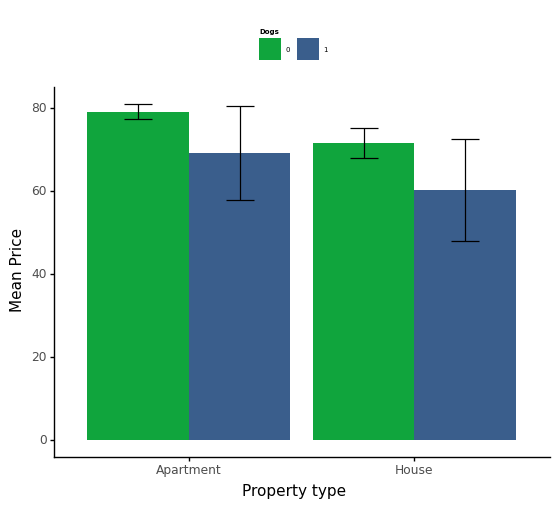

<ggplot: (315194387)>

In [37]:
price_diff_by_variables2(data, "f_property_type", "d_dogs", "Property type", "Dogs")

In [38]:
# dummies suggested by graphs
X1 = ("f_room_type*f_property_type",  "f_room_type*d_familykidfriendly")

In [39]:
# Additional interactions of factors and dummies
X2=("d_airconditioning*f_property_type", "d_cats*f_property_type", "d_dogs*f_property_type")
X3="(f_property_type + f_room_type + f_cancellation_policy + f_bed_type) * ("+ "+".join(amenities) +")"

In [40]:
modellev1="~ n_accommodates"
modellev2="~"+"+".join(basic_lev)
modellev3="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)
modellev4="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)
modellev5="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)
modellev6="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)
modellev7="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)
modellev8="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)+"+"+X3

In [41]:
#################################
# Separate hold-out set #
#################################
smp_size = round(0.2 * data.shape[0])-1

In [42]:
# Set the random number generator: It will make results reproducable
np.random.seed(20180123)

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
data_work,data_holdout=train_test_split(data, test_size=smp_size)

In [45]:
##############################
#      cross validation      #
##############################
## N = 5
n_folds=5

In [46]:
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse
k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

In [47]:
def cv_reg(formula, data, kfold, testdata, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [data_train["price"], model.predict(data_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [data_test["price"], model.predict(data_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [48]:
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
    modellev8,
]:
    cv_list += [cv_reg("price" + i, data, k, "HC0")]

In [49]:
summarize_cv(cv_list)


,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8
Fold1,42.224944,39.335372,38.279636,34.844526,34.770972,34.623380,33.607447,31.700812
Fold2,42.066027,39.238050,38.354196,33.955907,33.778094,33.648667,32.687292,30.911688
Fold3,38.938911,36.070842,35.282251,33.507214,33.397693,33.251641,32.342392,30.683789
Fold4,40.730742,38.290893,37.324689,32.407741,32.314413,32.091116,30.933210,28.847821
Fold5,42.228597,39.493288,38.582335,35.572399,35.458907,35.331049,34.218148,32.221048
Average,41.237844,38.485689,37.564621,34.057558,33.944016,33.789171,32.757698,30.873032


In [50]:
# RMSE training vs test graph

rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
rmse_levels = pd.DataFrame.from_dict(rmse_levels)
rmse_levels["nvars2"] = rmse_levels["nvars"] + 1

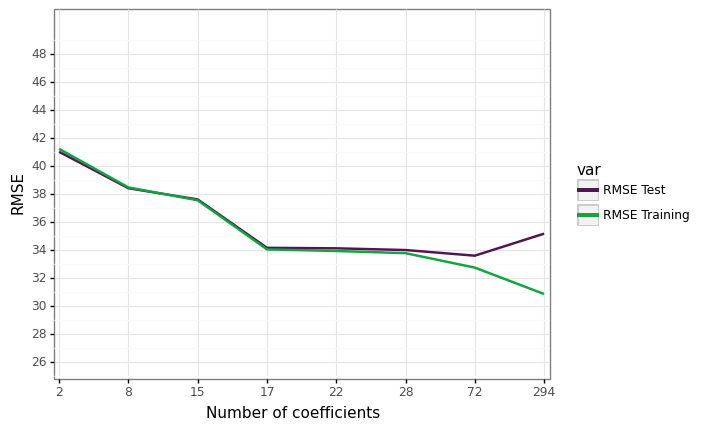

<ggplot: (315160787)>

In [51]:
(
    ggplot(rmse_levels, aes(x="factor(nvars2)", y="value", color="var", group="var"))
    + geom_line(size=1, show_legend=True, na_rm=True)
    + scale_color_manual(name="", values=(color[2], color[1]))
    + scale_y_continuous(name="RMSE", limits=(26, 50), breaks=seq(26, 50, 2))
    + scale_x_discrete(
        name="Number of coefficients",
        expand=(0.01, 0.01)
        # ) + geom_dl(aes(label = var),  method = list("last.points", dl.trans(x=x-1), cex=0.4)
    )
    + theme_bw()
)

In [52]:
#################################
#           LASSO               #
#################################

In [53]:
vars_model_7 = "(f_property_type + f_room_type + f_cancellation_policy + f_bed_type) * (d_24hourcheckin + d_airconditioning + d_breakfast + d_buzzerwirelessintercom + d_cabletv + d_carbonmonoxidedetector + d_cats + d_dogs + d_doorman + d_doormanentry + d_dryer + d_elevatorinbuilding + d_essentials + d_familykidfriendly + d_fireextinguisher + d_firstaidkit + d_freeparkingonpremises + d_freeparkingonstreet + d_gym + d_hairdryer + d_hangers + d_heating + d_hottub + d_indoorfireplace + d_internet + d_iron + d_keypad + d_kitchen + d_laptopfriendlyworkspace + d_lockonbedroomdoor + d_lockbox + d_otherpets + d_paidparkingoffpremises + d_petsallowed + d_petsliveonthisproperty + d_pool + d_privateentrance + d_privatelivingroom + d_safetycard + d_selfcheckin + d_shampoo + d_smartlock + d_smokedetector + d_smokingallowed + d_suitableforevents + d_tv + d_washer + d_washerdryer + d_wheelchairaccessible + d_wirelessinternet)"
vars_model_8 = modellev8

In [54]:
# LASSO
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
y, X = patsy.dmatrices("price" + vars_model_8, data)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=smp_size, random_state=10
)

lambdas = seq(0.05, 1, by=0.05)

train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))

In [55]:
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

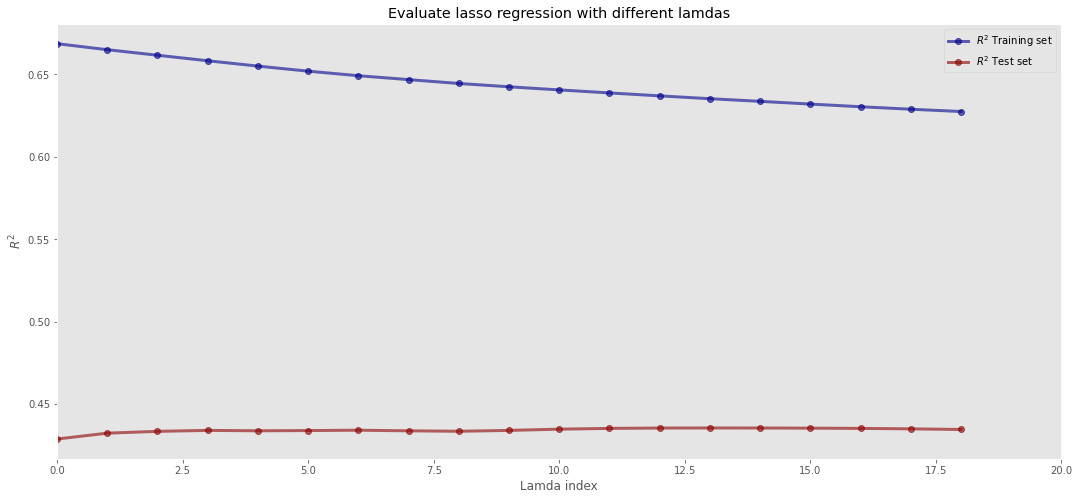

In [56]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(
    train_r_squared,
    "bo-",
    label=r"$R^2$ Training set",
    color="darkblue",
    alpha=0.6,
    linewidth=3,
)
plt.plot(
    test_r_squared,
    "bo-",
    label=r"$R^2$ Test set",
    color="darkred",
    alpha=0.6,
    linewidth=3,
)
plt.xlabel("Lamda index")
plt.ylabel(r"$R^2$")
plt.xlim(0, 20)
plt.title(r"Evaluate lasso regression with different lamdas")
plt.legend(loc="best")
plt.grid()

In [57]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    43.557995
lambda        0.700000
Name: 13, dtype: float64

In [58]:
reg_best = Lasso(alpha = df_lam.loc[df_lam['R_squared'].idxmax()]['lambda'])
reg_best.fit(X_train, y_train)

Lasso(alpha=0.7)

In [59]:
reg_best.coef_[reg_best.coef_>0]

array([ 0.73214289,  7.28208588,  0.18551492,  1.05954068, 17.81516317,
        0.90723608,  0.06133783,  1.01537939,  0.28478268,  0.48556371,
        0.35932847,  0.91662571,  1.39733979,  2.06614152,  0.62920389,
        0.07934937,  1.43837724,  0.28379985,  0.02101994,  0.59405321,
        0.05602722,  1.10853532,  1.53545321,  0.79041851,  0.14914377,
        1.07509534,  0.95145528,  0.32719317,  0.42377242,  4.16909763,
        1.20281378])

In [60]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, reg_best.predict(X_test))

1663.9476038970308

In [61]:
y,  X = patsy.dmatrices('price'+vars_model_8, data)

In [62]:
from sklearn.model_selection import GridSearchCV

# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv=cv)
# perform the search
results = search.fit(X, y)

In [63]:
print("RMSE: " + str(results.best_score_ * -1))

RMSE: 33.13458665033346


In [64]:
results

GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=Lasso(),
             param_grid={'alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring='neg_root_mean_squared_error')

In [65]:
########################################
# PART III.
########################################



###################################################
# Diagnsotics #
###################################################
model3_level = smf.ols('price'+modellev3, data=data_work).fit(cov_type='HC0')
model7_level = smf.ols('price'+modellev7, data=data_work).fit(cov_type='HC0')

In [66]:
# look at holdout RMSE
rmse_data = pd.concat(
    [data_work["price"], model7_level.predict(data_work)],
    axis=1,
    keys=["price", "predicted"],
)
rmse_data = rmse_data[~rmse_data.isna().any(axis=1)]
model7_level_work_rmse = rmse(rmse_data["price"], rmse_data["predicted"], axis=0)
rmse_data = pd.concat(
    [data_holdout["price"], model7_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
rmse_data = rmse_data[~rmse_data.isna().any(axis=1)]
model7_level_holdout_rmse = rmse(rmse_data["price"], rmse_data["predicted"], axis=0)
print(
    f"RMSE work:{round(model7_level_work_rmse,2)}",
    "\t",
    f"RMSE holdout:{round(model7_level_holdout_rmse,2)}",
)

RMSE work:32.53 	 RMSE holdout:34.8


In [67]:
###################################################
# FIGURES FOR FITTED VS ACTUAL OUTCOME VARIABLES #
###################################################

In [68]:
Ylev=data_holdout['price']
meanY=Ylev.mean()
sdY=Ylev.std()
meanY_m2SE = meanY -1.96 * sdY
meanY_p2SE = meanY + 1.96 * sdY
Y5p=Ylev.quantile(.05)
Y95p=Ylev.quantile(.95)

In [69]:
# Create data frame with the real and predicted values
dt = model7_level.get_prediction(data_holdout).summary_frame(alpha=0.05)
data_extra = pd.concat(
    [data_holdout["price"], model7_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
data_extra = data_extra[~data_extra.isna().any(axis=1)].reset_index(drop=True)
dt["Ylev"] = data_extra["price"]

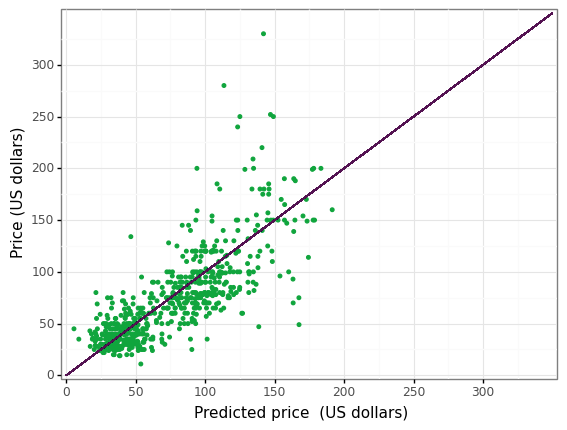

<ggplot: (315599999)>

In [70]:
(
    ggplot(data=dt)
    + geom_point(
        aes(y="Ylev", x="mean"),
        color=color[1],
        size=1,
        alpha=0.7,
        show_legend=False,
        na_rm=True,
    )
    + geom_segment(aes(x=0, y=0, xend=350, yend=350), size=0.5, color=color[2])
    + coord_cartesian(xlim=(0, 350), ylim=(0, 350))
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + labs(y="Price (US dollars)", x="Predicted price  (US dollars)")
    + theme_bw()
)

In [71]:
# Redo predicted values at 80% PI
dt = model7_level.get_prediction(data_holdout).summary_frame(alpha=0.2)
data_extra = pd.concat(
    [
        data_holdout["price"],
        data_holdout["n_accommodates"],
        model7_level.predict(data_holdout),
    ],
    axis=1,
    keys=["price", "n_accommodates", "predicted"],
)
data_extra = data_extra[~data_extra.isna().any(axis=1)].reset_index(drop=True)
dt["n_accommodates"] = data_extra["n_accommodates"]
dt["Ylev"] = data_extra["price"]
dt["elev"] = dt["Ylev"] - dt["mean"]

In [72]:
predictionlev_holdout_summary = dt.groupby(by=["n_accommodates"]).mean().reset_index()

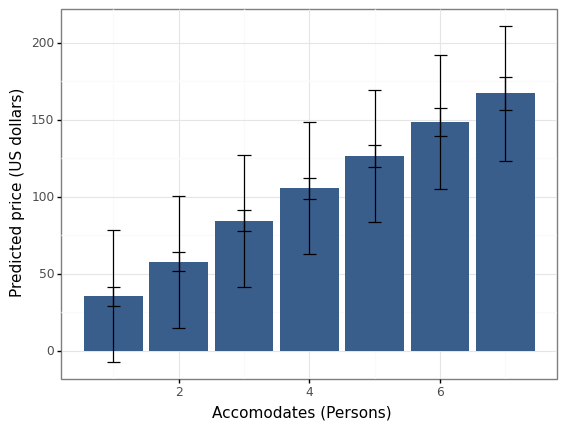

<ggplot: (315590226)>

In [73]:
(
    ggplot(predictionlev_holdout_summary, aes(x="n_accommodates"))
    + geom_bar(aes(y="mean"), stat="identity", fill=color[0], alpha=0.7)
    + geom_errorbar(aes(ymin="obs_ci_lower", ymax="obs_ci_upper"), width=0.2)
    + geom_errorbar(aes(ymin="mean_ci_lower", ymax="mean_ci_upper"), width=0.2)
    + scale_y_continuous(name="Predicted price (US dollars)")
    + scale_x_continuous(name="Accomodates (Persons)")
    + scale_color_manual(values=(color[1], color[1]))
    + theme_bw()
    + theme(legend_title=element_blank(), legend_position="none")
)

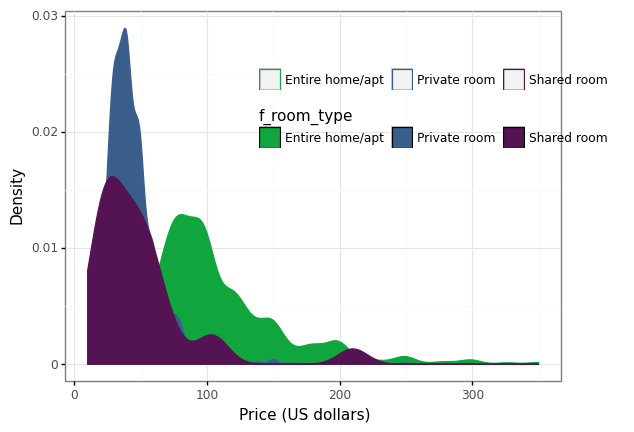

<ggplot: (317809080)>

In [74]:
# NOT USED
# Density chart (not in book)
(
    ggplot(datau, aes(x="price"))
    + geom_density(aes(color="f_room_type", fill="f_room_type"), na_rm=True, alpha=0.3)
    + labs(x="Price (US dollars)", y="Density", color="")
    + scale_color_manual(
        name="",
        values=(color[1], color[0], color[2]),
        labels=("Entire home/apt", "Private room", "Shared room"),
    )
    + scale_fill_manual(
        name="",
        values=(color[1], color[0], color[2]),
        labels=("Entire home/apt", "Private room", "Shared room"),
    )
    + theme_bw()
    + theme(
        legend_position=(0.7, 0.7),
        legend_direction="horizontal",
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)

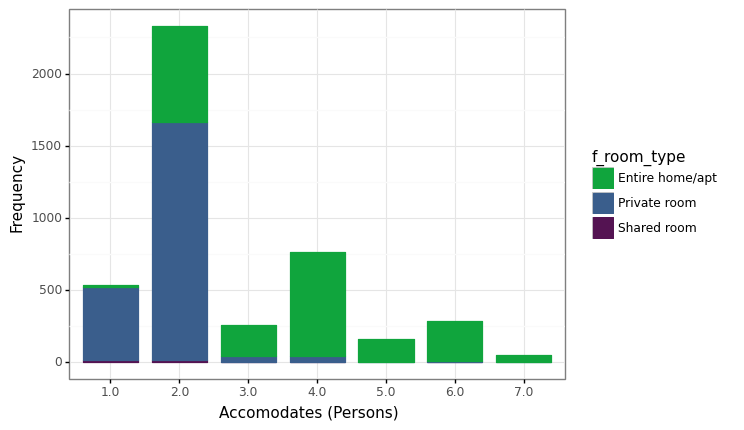

<ggplot: (315049617)>

In [75]:
# Barchart  (not in book)
(
    ggplot(
        datau, aes(x="factor(n_accommodates)", color="f_room_type", fill="f_room_type")
    )
    + geom_bar(alpha=0.8, na_rm=True, width=0.8)
    + scale_color_manual(name="", values=(color[1], color[0], color[2]))
    + scale_fill_manual(name="", values=(color[1], color[0], color[2]))
    + labs(x="Accomodates (Persons)", y="Frequency")
    + theme_bw()
    + theme(legend_position="right")
)